In [1]:
from architectures_v1 import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RNN
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, roc_auc_score

import os
import numpy as np
import tensorflow as tf
import pandas as pd
import time
import random

## Loading Training/Testing/Validation Data

In [2]:
dataset = "Wafer"
model_name = "laguerre"

x_train_load = np.load(os.path.abspath(os.path.join('99_data', dataset,'x_train.npz')))
x_test_load = np.load(os.path.abspath(os.path.join('99_data', dataset,'x_test.npz')))

x_train = np.reshape(x_train_load['arr_0'], [x_train_load['arr_0'].shape[0], x_train_load['arr_0'].shape[1], 1])
x_test = np.reshape(x_test_load['arr_0'], [x_test_load['arr_0'].shape[0], x_test_load['arr_0'].shape[1], 1])

x_all = np.concatenate((x_train, x_test), axis = 0)

n_instances = x_all.shape[0]

y_train_load = np.load(os.path.abspath(os.path.join('99_data', dataset,'y_train.npz')))
y_test_load = np.load(os.path.abspath(os.path.join('99_data', dataset,'y_test.npz')))

y_train = y_train_load['arr_0']
y_test = y_test_load['arr_0']

y_all = np.concatenate((y_train, y_test), axis = 0)
y_all = np.asarray(y_all, dtype = np.uint64)

n_validation = int(0.1*n_instances)
print(f"Validation Instances: {n_validation}")

ind_validation = random.sample(range(0, n_instances), n_validation)
x_valid = x_all[ind_validation, :, :]
y_valid = y_all[ind_validation]

x_all = np.delete(x_all, ind_validation, axis = 0)
y_all = np.delete(y_all, ind_validation, axis = 0)

print(f"x_all: {x_all.shape} - y_all: {y_all.shape}")
print(f"x_valid: {x_valid.shape} - y_valid: {y_valid.shape}")

Validation Instances: 716
x_all: (6448, 152, 1) - y_all: (6448,)
x_valid: (716, 152, 1) - y_valid: (716,)


In [3]:
seed = 42
tf.random.set_random_seed(seed)
np.random.seed(seed)

length = x_all.shape[1]
n_features = x_all.shape[-1]

model = Sequential()

model.add(RNN(OrthogonalCell(units = 212,
                             order = 256,
                             variant = 'ct_laguerre',
                             dt = 1,
                            input_dims = n_features), 
              input_shape = (length, n_features),
             return_sequences = False))
model.add(Dense(to_categorical(y_all).shape[-1], activation = "softmax"))

model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, 212)               165691    
_________________________________________________________________
dense (Dense)                (None, 2)                 426       
Total params: 166,117
Trainable params: 100,323
Non-trainable params: 65,794
_________________________________________________________________


In [46]:
if not os.path.exists(os.path.abspath(os.path.join('models', dataset))):
    os.mkdir(os.path.abspath(os.path.join('models', dataset)))

kf = KFold(n_splits = 5)
sdk = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
df_tpr = pd.DataFrame(columns = [1, 2, 3, 4, 5])
df_fpr = pd.DataFrame(columns = [1, 2, 3, 4, 5])

n_fold = 1

acc_per_fold = []
epoch_per_fold = []
loss_per_fold = []
rec_per_fold = []
prec_per_fold = []
f1_per_fold = []
auroc_per_fold = []
fpr_per_fold = []
tpr_per_fold = []

for train, test in sdk.split(x_all, y_all):
    
    file_path = os.path.abspath(os.path.join('models', dataset, f'{dataset}-{model_name}_{n_fold}.hdf5'))

    callbacks = [
        ModelCheckpoint(filepath=file_path, monitor='val_loss', save_best_only = True, mode = 'min', verbose = 1), 
        EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min')]

    t = time.time()
    
    print(f"\nFold: {n_fold}\n")
    result = model.fit(x_all[train], 
                       to_categorical(y_all[train]),
                       epochs = 200, 
                       batch_size = 100, 
                       validation_data = (x_valid, to_categorical(y_valid)), 
                       callbacks = callbacks)

    print(f"Training time: {time.time() - t} s")

    df_results = pd.DataFrame(result.history)
    df_results.to_csv(os.path.abspath(os.path.join('models', dataset, f'{model_name}_results_{n_fold}.csv')))
    
    model.load_weights(file_path)
    scores = model.evaluate(x_all[test], to_categorical(y_all[test]))
    loss_per_fold.append(scores[0])
    acc_per_fold.append(scores[1])
    epoch_per_fold.append(np.argmin(result.history['val_loss']))
    
    # Computing predictions
    y_pred_test = np.argmax(model.predict(x_all[test]), axis = 1)
    
    # Getting performance scores per fold
    f1_per_fold.append(f1_score(y_all[test], y_pred_test, average = 'macro'))
    rec_per_fold.append(recall_score(y_all[test], y_pred_test, average = 'macro'))
    prec_per_fold.append(precision_score(y_all[test], y_pred_test, average = 'macro'))
    auroc_per_fold.append(roc_auc_score(y_all[test], y_pred_test, average = 'macro'))
    
    # Getting ROC curve for this binary classification task
    
    fpr, tpr, _ = roc_curve(y_all[test], model.predict(x_all[test])[:,1])
    
    df_fpr[n_fold] = fpr
    df_tpr[n_fold] = tpr
        
    n_fold += 1

df_scores = pd.DataFrame(columns = ['F1', 'Loss', 'Accuracy', 'Precision', 'Recall', 'AUROC'])
df_scores['F1'] = f1_per_fold
df_scores['Loss'] = loss_per_fold
df_scores['Accuracy'] = acc_per_fold
df_scores['Precision'] = prec_per_fold
df_scores['Recall'] = rec_per_fold
df_scores['AUROC'] = auroc_per_fold

df_scores.to_csv(os.path.abspath(os.path.join('models', dataset, f'{model_name}_results_k-Folds.csv')))
df_tpr.to_csv(os.path.abspath(os.path.join('models', dataset, f'{model_name}_results_k-Folds_tpr.csv')))
df_fpr.to_csv(os.path.abspath(os.path.join('models', dataset, f'{model_name}_results_k-Folds_fpr.csv')))


Fold: 1

Train on 5158 samples, validate on 716 samples
Epoch 1/200
5100/5158 [============================>.] - ETA: 0s - loss: 0.0050 - acc: 0.9992
Epoch 00001: val_loss improved from inf to 0.00436, saving model to /Users/sergio.dorado/Documents/GitHub_Repositories/01_Maintained/NeuralODE/models/Wafer/Wafer-laguerre_1.hdf5
5158/5158 [==============================] - 8s 2ms/sample - loss: 0.0049 - acc: 0.9992 - val_loss: 0.0044 - val_acc: 0.9986
Epoch 2/200
5100/5158 [============================>.] - ETA: 0s - loss: 0.0028 - acc: 0.9998
Epoch 00002: val_loss improved from 0.00436 to 0.00314, saving model to /Users/sergio.dorado/Documents/GitHub_Repositories/01_Maintained/NeuralODE/models/Wafer/Wafer-laguerre_1.hdf5
5158/5158 [==============================] - 9s 2ms/sample - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0031 - val_acc: 0.9986
Epoch 3/200
5100/5158 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.9998
Epoch 00003: val_loss improved from 0.00314 to 0.00

KeyboardInterrupt: 

In [30]:
y_all[test].shape

(1289,)

(81,)


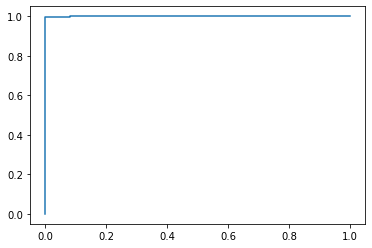

In [45]:
import matplotlib.pyplot as plt

print(fpr.shape)

plt.plot(fpr, tpr)

In [34]:
model.predict_proba(x_all[test])[:,0].shape

(1289,)

In [24]:
model.predict_proba(x_all[test])[0,:]

array([3.810608e-04, 9.996189e-01], dtype=float32)